# Final Project

In [146]:
import pickle
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
sns.set_style("whitegrid")

In [186]:
# Load the data
with open('data_v2.pickle', 'rb') as g:
    df = pickle.load(g)

In [188]:
df.shape

(1198, 82)

In [148]:
# remove statistics from 1981, 1994, 1995 (all due to strikes) and 2020 (covid) with shorter seasons
NG_year = [1981, 1994, 1995, 2020]
year = df.year
good_index = [i not in NG_year for i in year]
df = df[good_index].reset_index(drop=True)

In [149]:
df.year.unique()

array([1980., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2021.])

In [150]:
# keep only numeric variables and remove columns without enough observations (the last 3)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
baseball = df.select_dtypes(include=numerics)

In [151]:
baseball.columns

Index(['year', 'b_batters_used', 'b_age_bat', 'b_runs_per_game', 'b_G', 'b_PA',
       'b_AB', 'b_R', 'b_H', 'b_2B', 'b_3B', 'b_HR', 'b_RBI', 'b_SB', 'b_CS',
       'b_BB', 'b_SO', 'b_batting_avg', 'b_onbase_perc', 'b_slugging_perc',
       'b_onbase_plus_slugging', 'b_onbase_plus_slugging_plus', 'b_TB',
       'b_GIDP', 'b_HBP', 'b_SH', 'b_SF', 'b_IBB', 'b_LOB', 'p_pitchers_used',
       'p_age_pitch', 'p_runs_allowed_per_game', 'p_W', 'p_L',
       'p_win_loss_perc', 'p_earned_run_avg', 'p_G', 'p_GS', 'p_GF', 'p_CG',
       'p_SHO_team', 'p_SHO_cg', 'p_SV', 'p_IP', 'p_H', 'p_R', 'p_ER', 'p_HR',
       'p_BB', 'p_IBB', 'p_SO', 'p_HBP', 'p_BK', 'p_WP', 'p_batters_faced',
       'p_earned_run_avg_plus', 'p_fip', 'p_whip', 'p_hits_per_nine',
       'p_home_runs_per_nine', 'p_bases_on_balls_per_nine',
       'p_strikeouts_per_nine', 'p_strikeouts_per_base_on_balls', 'p_LOB',
       'f_fielders_used', 'f_runs_allowed_per_game', 'f_defensive_efficiency',
       'f_G', 'f_GS', 'f_CG', 'f_Inn

## Clean up the dataframe a bit. Removing some redundant columns.

In [152]:
columns_to_be_dropped = ['b_batters_used', 'b_G', 'b_age_bat', 'b_PA', 'b_AB',
                        'p_pitchers_used', 'p_age_pitch', 'p_W', 'p_L',
                         'p_G', 'p_GS', 'p_GF', 'p_IP',
                        'f_fielders_used', 'f_G', 'f_GS', 'f_CG', 'f_Inn_def']
baseball = baseball.drop(columns=columns_to_be_dropped)

In [153]:
# directly plug a linear regression model to see how it goes

X = baseball.drop(columns='p_win_loss_perc')
X = sm.add_constant(X)
y = baseball['p_win_loss_perc']
model = sm.OLS(y, X)
car_model = model.fit()
car_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        p_win_loss_perc   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     485.0
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:09:57   Log-Likelihood:                 3150.7
No. Observations:                1086   AIC:                            -6185.
Df Residuals:                    1028   BIC:                            -5896.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.0865      1.642     -3.097      0.002      -8.309      -1.864
year                               0.0001      0.000      0.786      0.432      -0.000       0.000
b_runs_per_game                   -0.0025      0.106     -0.024      0.981      -0.210       0.205
b_R                                0.0015      0.001      2.209      0.027       0.000       0.003
b_H                               -0.0026      0.000    -12.183      0.000      -0.003      -0.002
b_2B                            5.841e-05   3.05e-05      1.918      0.055   -1.36e-06       0.000
b_3B                               0.0001   6.25e-05      2.016      0.044    3.38e-06       0.000
b_HR                               0.0003   6.98e-05      5.005      0.000       0.000       0.000
b_RBI                           5.268e-05    6.7e-05      0.786      0.432   -7.88e-05       0.000
b_SB                            1.244e-05   1.72e-05      0.722      0.470   -2.14e-05    4.62e-05
b_CS                            4.446e-06   6.09e-05      0.073      0.942      -0.000       0.000
b_BB                              -0.0022      0.000    -16.804      0.000      -0.002      -0.002
b_SO                            2.482e-06   5.54e-06      0.448      0.654    -8.4e-06    1.34e-05
b_batting_avg                      7.4716      1.272      5.875      0.000       4.976       9.967
b_onbase_perc                      2.4430      1.198      2.038      0.042       0.091       4.795
b_slugging_perc                    0.0519      1.150      0.045      0.964      -2.205       2.309
b_onbase_plus_slugging             6.0888      0.968      6.293      0.000       4.190       7.987
b_onbase_plus_slugging_plus        0.0001      0.000      0.713      0.476      -0.000       0.001
b_TB                              -0.0012      0.000     -9.575      0.000      -0.001      -0.001
b_GIDP                           7.14e-06   4.89e-05      0.146      0.884   -8.89e-05       0.000
b_HBP                             -0.0022      0.000    -16.284      0.000      -0.002      -0.002
b_SH                              -0.0013   5.17e-05    -24.712      0.000      -0.001      -0.001
b_SF                              -0.0009    8.7e-05    -10.308      0.000      -0.001      -0.001
b_IBB                              0.0001   4.32e-05      2.636      0.009    2.91e-05       0.000
b_LOB                              0.0012   5.42e-05     23.039      0.000       0.001       0.001
p_runs_allowed_per_game            0.0140      0.052      0.270      0.787      -0.088       0.116
p_earned_run_avg                   0.0480      0.103      0.467      0.641      -0.154       0.250
p_CG                               0.0002      0.000      2.023      0.043    6.19e-06       0.000
p_SHO_team    

## Select 12 features to investigate further.

In [154]:
features = ['b_runs_per_game', 'b_RBI', 'b_onbase_perc', 'b_slugging_perc', 'b_onbase_plus_slugging',
            'p_runs_allowed_per_game', 'p_earned_run_avg', 'p_SV', 'p_SO', 'p_whip',
            'f_E_def', 'f_fielding_perc']

In [155]:
X = baseball[features]
y = baseball['p_win_loss_perc']
smaller_baseball = pd.concat([X, y], axis=1)
X = sm.add_constant(X)

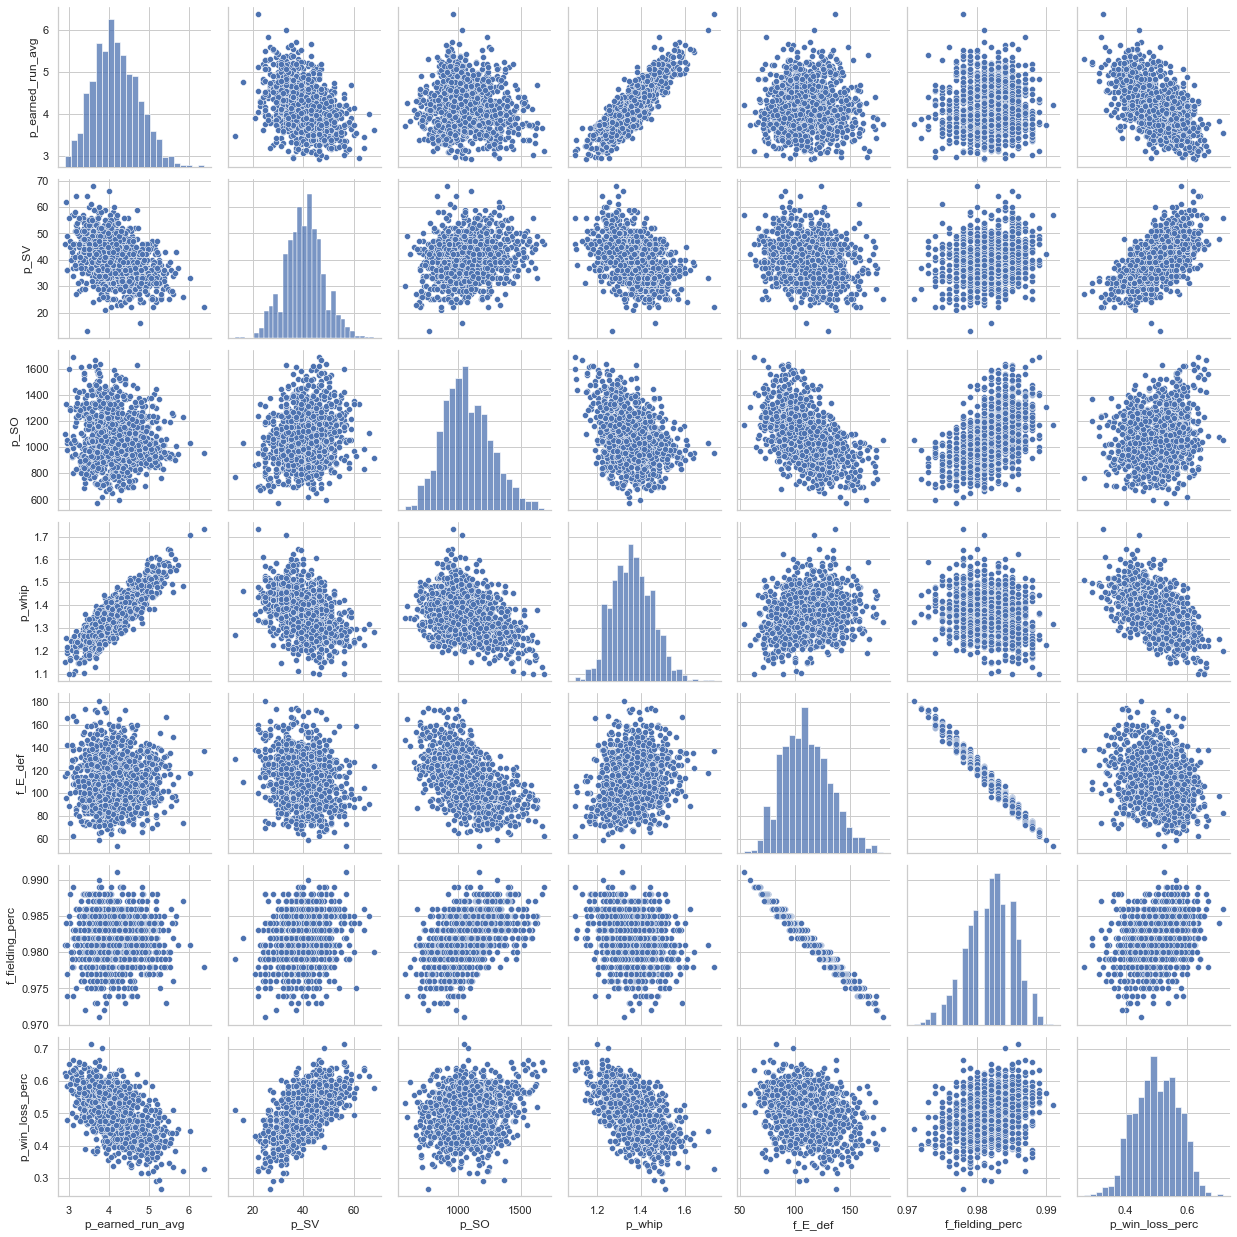

In [156]:
sns.pairplot(smaller_baseball.iloc[:, 6:13]);

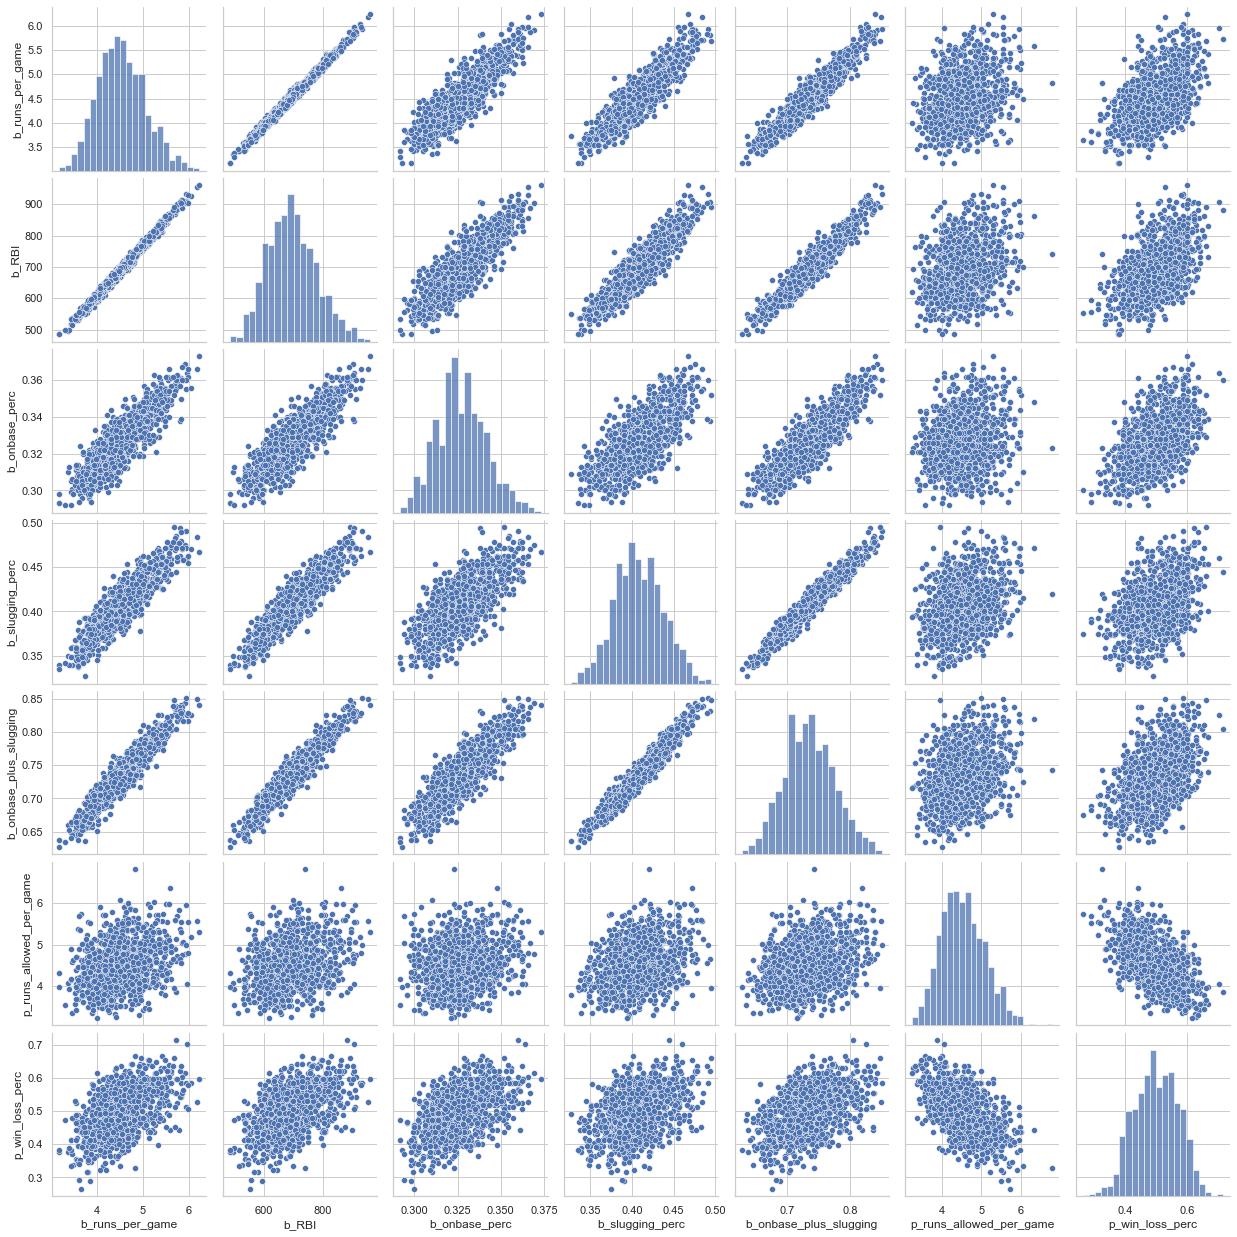

In [157]:
sns.pairplot(smaller_baseball.iloc[:, [0, 1, 2, 3, 4, 5, 12]]);

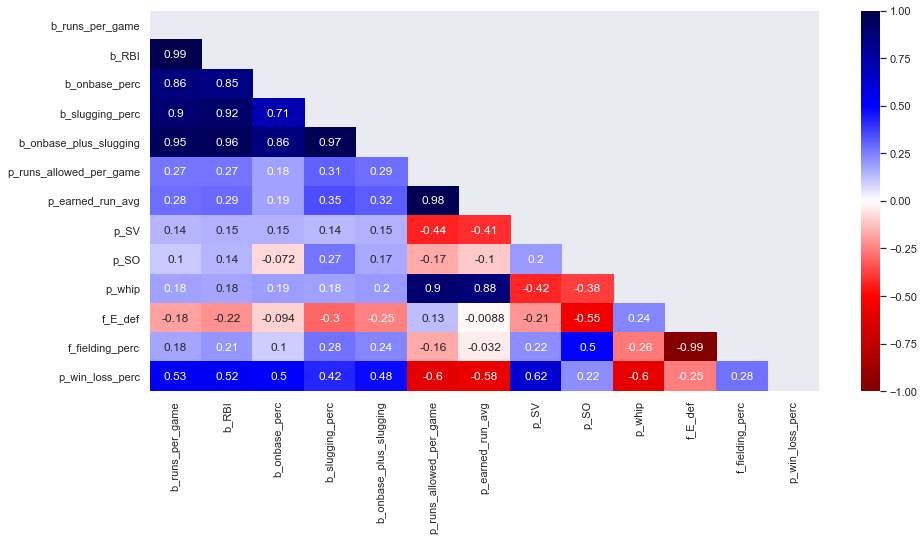

In [169]:
sns.set(rc = {'figure.figsize':(15, 7)})
upper = np.triu(smaller_baseball.corr())
sns.heatmap(smaller_baseball.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);
plt.savefig('correlation.png')

### There are three groups of features with high correlation with each other. We will do something with them later.
1. 
* b_runs_per_game
* b_RBI
* b_onbase_perc
* b_slugging_perc
* b_onbase_plus_slugging

2. 
* p_runs_allowed_per_game
* p_earned_run_avg
* p_whip

3. 
* f_E_def
* f_fielding_perc

In [159]:
model = sm.OLS(y, X)
baseball_model = model.fit()
baseball_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        p_win_loss_perc   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     955.6
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:10:18   Log-Likelihood:                 2678.3
No. Observations:                1086   AIC:                            -5331.
Df Residuals:                    1073   BIC:                            -5266.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.5197      1.523      0.341      0.733      -2.469       3.509
b_runs_per_game             0.0858      0.014      6.337      0.000       0.059       0.112
b_RBI                   -2.726e-05   8.95e-05     -0.305      0.761      -0.000       0.000
b_onbase_perc              -1.3096      1.306     -1.002      0.316      -3.873       1.254
b_slugging_perc            -1.4915      1.305     -1.143      0.253      -4.052       1.069
b_onbase_plus_slugging      1.5605      1.304      1.197      0.232      -0.997       4.119
p_runs_allowed_per_game    -0.0417      0.010     -4.134      0.000      -0.062      -0.022
p_earned_run_avg           -0.0379      0.010     -3.745      0.000      -0.058      -0.018
p_SV                        0.0020   9.68e-05     21.023      0.000       0.002       0.002
p_SO                    -9.023e-06   5.02e-06     -1.798      0.073   -1.89e-05    8.26e-07
p_whip                     -0.0559      0.019     -2.889      0.004      -0.094      -0.018
f_E_def                    -0.0001      0.000     -0.588      0.557      -0.001       0.000
f_fielding_perc            -0.1356      1.522     -0.089      0.929      -3.121       2.850
==============================================================================
Omnibus:                        3.766   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.179
Skew:                           0.034   Prob(JB):                        0.204
Kurtosis:                       2.744   Cond. No.                     4.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
features_2 = ['b_runs_per_game',
              'p_SV', 'p_earned_run_avg',
              'f_E_def']
X = baseball[features_2]
y = baseball['p_win_loss_perc']
X = sm.add_constant(X)
model = sm.OLS(y, X)
baseball_model = model.fit()
baseball_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        p_win_loss_perc   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     2775.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:46:37   Log-Likelihood:                 2658.5
No. Observations:                1086   AIC:                            -5307.
Df Residuals:                    1081   BIC:                            -5282.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3998      0.010     41.568      0.000       0.381       0.419
b_runs_per_game      0.0902      0.001     67.080      0.000       0.088       0.093
p_SV                 0.0021   9.72e-05     21.389      0.000       0.002       0.002
p_earned_run_avg    -0.0866      0.001    -63.094      0.000      -0.089      -0.084
f_E_def             -0.0003   3.06e-05     -9.328      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        5.681   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                4.493
Skew:                           0.046   Prob(JB):                        0.106
Kurtosis:                       2.699   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking for outliers

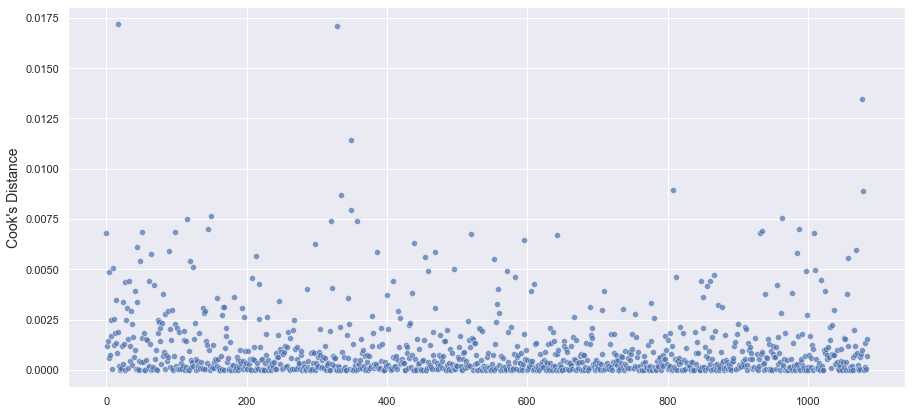

In [194]:
influence = baseball_model.get_influence()
influence_frame = influence.summary_frame().reset_index()
#influence_frame
sns.set(rc = {'figure.figsize':(15, 7)})
p = sns.scatterplot(y='cooks_d', x=influence_frame.index, data=influence_frame, alpha=0.7)
p.set_ylabel("Cook's Distance", fontsize = 14);
plt.savefig('influence_frame.png')

## Checking for collinearity - VIF

In [162]:
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,const,228.437612
1,b_runs_per_game,1.212393
2,p_SV,1.370481
3,p_earned_run_avg,1.408180
4,f_E_def,1.076628


It seems there is some collinearity, but I will deal with it with regularization later.

## Checking for normality - residuals should be normally distributed with a mean of zero

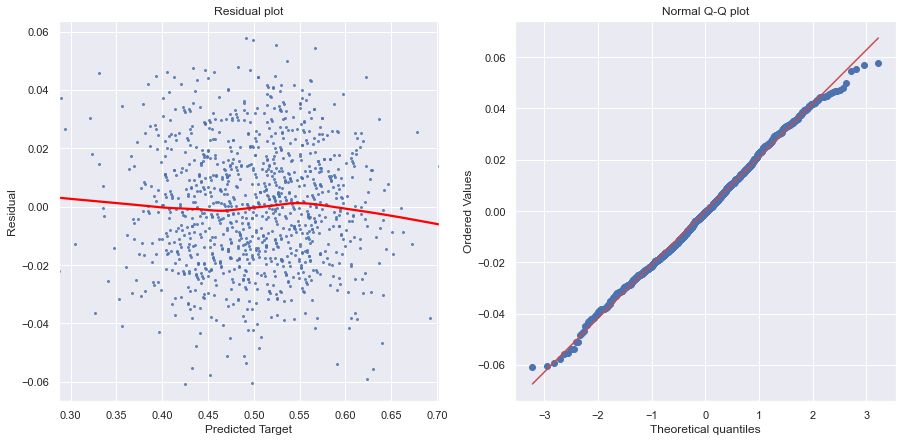

In [163]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
g = sns.regplot(x=baseball_model.fittedvalues, y=baseball_model.resid,
                lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 4})
g.set_xlabel('Predicted Target')
g.set_ylabel('Residual')
plt.title("Residual plot")

plt.subplot(1, 2, 2)
stats.probplot(baseball_model.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

plt.savefig('residual_analysis.png')

In [202]:
features_3 = ['b_runs_per_game',
              'p_SV', 'p_earned_run_avg',
              'f_E_def']

X = baseball[features_3]
y = baseball['p_win_loss_perc']

#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X, y)

# Check the R-squared value of the model on the training data
print('Train score: ', lr.score(X, y))
#print('Test score: ', lr.score(X_test, y_test))
# list the coefficients
print('Intercept: ', lr.intercept_)
list(zip(X.columns, lr.coef_))

Train score:  0.9112425377529267
Intercept:  0.39982192673853595


[('b_runs_per_game', 0.09021198645871333),
 ('p_SV', 0.0020792735326130058),
 ('p_earned_run_avg', -0.08657420349546767),
 ('f_E_def', -0.0002855798739248453)]

## Run linear regression model for years before and include year 2000, and compared with data after year 2000

In [177]:
df_1980 = df[df.year <= 2000]
baseball_1980 = df_1980.select_dtypes(include=numerics)
df_2020 = df[df.year > 2000]
baseball_2020 = df_2020.select_dtypes(include=numerics)

In [185]:
X = baseball_1980[features_3]
y = baseball_1980['p_win_loss_perc']

#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

X_2020 = baseball_2020[features_3]
y_2020 = baseball_2020['p_win_loss_perc']

lr = LinearRegression()
lr.fit(X, y)

# Check the R-squared value of the model on the training data
print('Train (<= 2000) score: ', lr.score(X, y))
print('Test (> 2000) score: ', lr.score(X_2020, y_2020))
# list the coefficients
print('Intercept: ', lr.intercept_)
list(zip(X.columns, lr.coef_))

Train (<= 2000) score:  0.8913986206017807
Test (> 2000) score:  0.9193442000673094
Intercept:  0.4327024530101028


[('b_runs_per_game', 0.09404997846112782),
 ('p_SV', 0.0016249348457679838),
 ('p_earned_run_avg', -0.09248208195946878),
 ('f_E_def', -0.0003423780468751286)]

In [179]:
lr = LinearRegression()
lr.fit(X_2020, y_2020)

# Check the R-squared value of the model on the training data
print('Train (> 2000) score: ', lr.score(X_2020, y_2020))
print('Test (<= 2000) score: ', lr.score(X, y))
# list the coefficients
print('Intercept: ', lr.intercept_)
list(zip(X.columns, lr.coef_))

Train (> 2020) score:  0.9281678510912379
Test (<= 2000) score:  0.8721460810394712
Intercept:  0.36139200697896695


[('b_runs_per_game', 0.08814304471143769),
 ('p_SV', 0.0026265084582189338),
 ('p_earned_run_avg', -0.07947752734702891),
 ('f_E_def', -0.0003375549983887727)]